In [49]:
from mantaray.core import single_ray, ray_tracing
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

### General Functions

In [127]:
def safe_ray_step(dl, v, fos=1.5):
    return dl/v * fos

def snells_law_bathymetry(phi, old_c, new_c):
    return np.arcsin(np.sin(phi)*new_c/old_c)

def snells_law_shear_current(phi, old_c, v):
    return np.arcsin(np.sin(phi) / (1- v/old_c*np.sin(phi))**2)

def analytical_ray_trace(xs, y0, phi0, cs, mode='shallow_bathymetry', v_currents=None):
    '''
    Analytically trace ray at angle phi0 from x axis with wavenumber k0, starting from x0, y0, through points
    xs (where each xs is a point where the ray refracts). Optionally accounts for ray displacement due to shear V
    current, using vs, where each value of vs corresponds to a segment between xs values
    Args:
        xs:
        y0:
        mode (str): Select which version of snell's law is used to compute refraction. Determines which
        optional arguments analytical_ray_trace() uses among depths, v_currents

    '''
    # Initialize Arrays for phis and ys with len = 1 less than xs (don't need final point)
    phis = np.ones(shape=len(xs)-1)
    phis[0] = phi0
    ys = np.ones(shape=len(xs))
    ys[0] = y0

    # If no currents provided, initialize array of 0s
    if v_currents is None:
        v_currents = np.zeros(shape=len(xs)-1)

    # set mode for computing refraction
    snells_law_func_dict = {'shallow_bathymetry':snells_law_bathymetry, 'shear_currents':snells_law_shear_current}
    snells_law_func = snells_law_func_dict[mode]

    #Iterate over each xs aside from last 2, computing phi then ys for next value
    for i, x, in enumerate(xs[:-2]):
        # Compute new phi
        snells_law_args_dict = {'shallow_bathymetry':{'phi':phis[i], 'old_c':cs[i], 'new_c':cs[i+1]},
                           'shear_currents':{'phi':phis[i], 'old_c':cs[i], 'v':v_currents[i+1]}}
        snells_law_args = snells_law_args_dict[mode]
        phis[i+1] = snells_law_func(**snells_law_args)

        # Compute new y value for ray
        ys[i+1] = ys[i] + np.tan(phis[i])*(xs[i+1] - xs[i])

        # Modify for advection from currents
        # Compute time for wave to travel x distance
        t = (xs[i+1] - xs[i]) / (cs[i]*np.tan(phis[i]))

        # Adjust y by distance wave advects in that time
        ys[i+1] = ys[i+1] + t*v_currents[i]
    
    # Compute final y value
    ys[-1] = ys[-2] + np.tan(phis[-1])*(xs[-1] - xs[-2])

    # Modify for advection from currents
    # Compute time for wave to travel x distance
    t = (xs[-1] - xs[-2]) / (cs[-1]*np.tan(phis[-1]))

    # Adjust y by distance wave advects in that time
    ys[-1] = ys[-1] + t*v_currents[-1]

    return phis, ys

## Step Function Bathymetry

### Import and Verify Data

Text(0.5, 1.0, 'V Current')

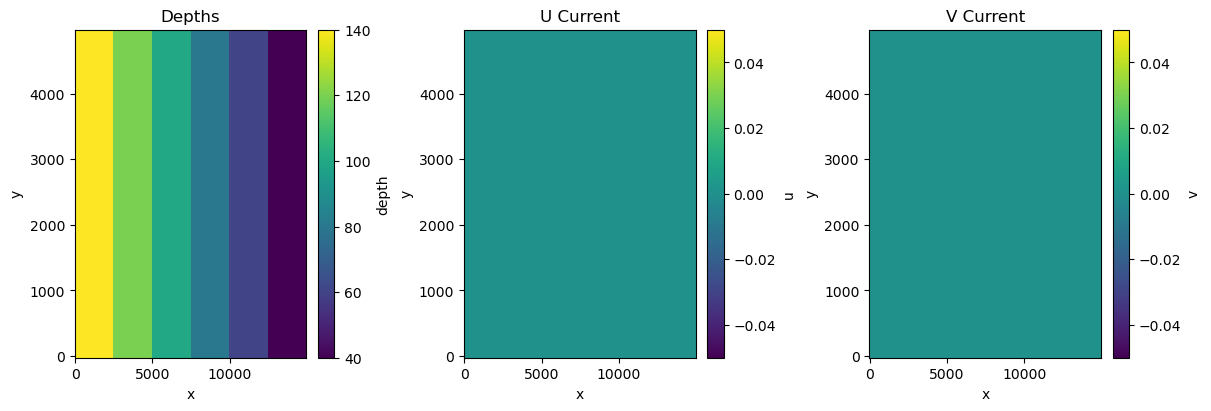

In [51]:
step_bathymetry_path = 'data/step_bathymetry.nc'
null_current_path = 'data/null_current.nc'
step_bathymetry = xr.open_dataset(step_bathymetry_path)
null_current = xr.open_dataset(null_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12,4), layout='constrained')
step_bathymetry.depth.plot(ax=ax_list[0])
null_current.u.plot(ax=ax_list[1])
null_current.v.plot(ax=ax_list[2])
ax_list[0].set_title('Depths')
ax_list[1].set_title('U Current')
ax_list[2].set_title('V Current')

### Define Ray and Run Ray Trace

In [59]:
# Define Environment Parameters
depth_max = step_bathymetry.depth.max().values
NY, NX = step_bathymetry.depth.shape
dl = np.diff(step_bathymetry.x.values)[0]
depth_levels_raw, depth_indices_raw = np.unique(step_bathymetry.depth.values, return_index=True)
depth_levels = np.flip(depth_levels_raw)
depth_indices = np.flip(depth_indices_raw)
n_shelfs = len(depth_levels)

# Define wave Parameters
k = 2*np.pi/20000 # lambda = 100m
phi0 = 20*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)
omega = np.sqrt(depth_max*9.81)*k

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [53]:
# Run Single Ray Trace with bathymetry and null current developed above
ray_evolution_raw = single_ray(x0, y0, kx, ky, 1000, 0.5,
                           bathymetry='data/step_bathymetry.nc',
                           current='data/null_current.nc')
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
                                         phi = np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx))

### Analytically Solve for Ray Path

In [ ]:
cs = np.sqrt(9.81*depth_levels)
# Pick x values corresponding to the different boundaries
shelf_edge_xs = step_bathymetry.x.values[depth_indices]
xs_analytical = np.append(shelf_edge_xs, step_bathymetry.x.values[-1]) #Add final right side boundary to xs_analytical
mid_shelf_xs = shelf_edge_xs + np.diff(xs_analytical)/2

phis_analytical, ys_analytical = analytical_ray_trace(xs_analytical, y0, phi0, cs, mode='shallow_bathymetry')

### Compute Ray Trace Error and Plot Rays

In [92]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(data=ray_evolution.phi.values[:-1], coords={'x':ray_evolution.x.values[:-1]})

# Find the difference and percent difference between the analytical and computational ray traces
phi_diffs = np.abs(phis_analytical - ray_angles.sel(x=mid_shelf_xs, method='nearest'))
phi_diffs_percent = phi_diffs / phis_analytical * 100
print('Ray Trace Angle Absolute Difference from Theory:', phi_diffs.values, 'degrees')
print('Ray Trace Angle Percent Difference from Theory:', phi_diffs_percent.values, '%')

Ray Trace Angle Absolute Difference from Theory: [5.55111512e-17 3.16648959e-04 1.49893906e-03 2.78956811e-03
 1.60210348e-03 8.12510841e-04] degrees
Ray Trace Angle Percent Difference from Theory: [1.59027734e-14 9.82787498e-02 5.11156674e-01 1.06670122e+00
 7.09463225e-01 4.41938783e-01] %


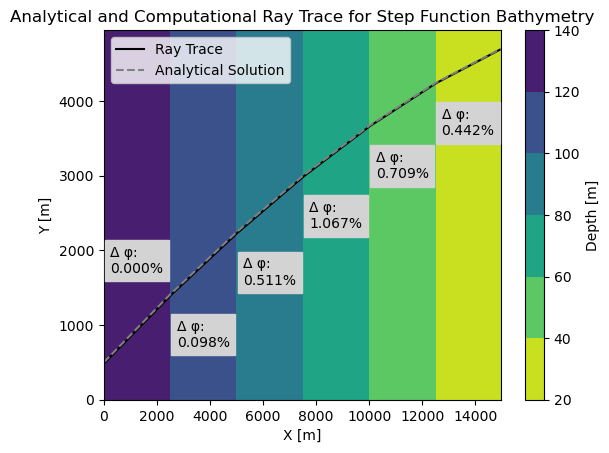

In [100]:
# Plot the Ray Comparisons
fig, ax = plt.subplots()
contours = ax.contourf(step_bathymetry.x, step_bathymetry.y, step_bathymetry.depth, cmap='viridis_r', levels=np.flip(np.concatenate((depth_levels, np.array([20,])))))
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black', label='Ray Trace')
ax.plot(xs_analytical, ys_analytical, marker='', linestyle='dashed', color='grey', label='Analytical Solution')
for i, pcent_diff in enumerate(phi_diffs_percent):
    if i == 0:
        ax.text(x=mid_shelf_xs[i] - 1000, y=ys_analytical[i]+1200, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
        continue
    ax.text(x=mid_shelf_xs[i] - 1000, y=ys_analytical[i]-700, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
ax.legend()
ax.set_title(label='Analytical and Computational Ray Trace for Step Function Bathymetry')
ax.set_xlabel(xlabel='X [m]')
ax.set_ylabel(ylabel='Y [m]')
cax = fig.colorbar(contours, label='Depth [m]')

Snell's Law (For Bathymetry Only):

$\frac{sin(\phi_1)}{sin(\phi_2)} = \frac{c_1}{c_2} = \frac{|\vec{K_2}|}{|\vec{K_1}|}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ and $c_2$ are the phase speeds of the wave before and after crossing the interface, and $\vec{K_1}$ and $\vec{K_2}$ are the wavenumbers of the incident and transmitted waves, respectively.

In the shallow water approximation, $c = \sqrt{g d}$, where g is the acceleration of gravity and d is the depth of the wave.

## Shear Current

### Import and Verify Data

Text(0.5, 1.0, 'V Current')

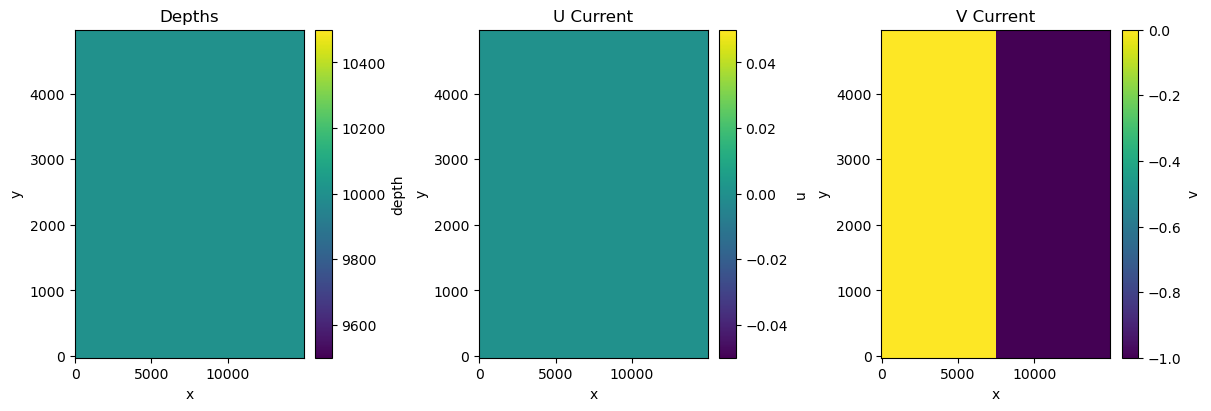

In [121]:
deep_flat_bathymetry_path = 'data/deep_water_flat_bathymetry.nc'
shear_current_path = 'data/shear_current_-1v.nc'
deep_flat_bathymetry = xr.open_dataset(deep_flat_bathymetry_path)
shear_current = xr.open_dataset(shear_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12,4), layout='constrained')
deep_flat_bathymetry.depth.plot(ax=ax_list[0])
shear_current.u.plot(ax=ax_list[1])
shear_current.v.plot(ax=ax_list[2])
ax_list[0].set_title('Depths')
ax_list[1].set_title('U Current')
ax_list[2].set_title('V Current')

### Define Ray and Run Ray Trace

In [128]:
# Define Environment Parameters

v_currents_raw, v_current_indices = np.unique(shear_current.v.values, return_index=True)
v_currents = np.flip(v_currents_raw)
v_current_indices = np.flip(v_current_indices)
n_zones = len(v_currents)

# Define wave number
k = 2*np.pi/10 # lambda = 50m
phi0 = 15*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [129]:
ray_evolution_raw = single_ray(x0, y0, kx, ky, 40000, 10,
                           bathymetry='data/deep_water_flat_bathymetry.nc',
                           current='data/shear_current_-1v.nc')
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
                                         phi = np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx))

### Analytically Solve for Ray Path

In [130]:
c = np.sqrt(9.81/k)
cs = np.ones_like(v_currents)*c

# Pick x values corresponding to the different boundaries
zone_edge_xs = shear_current.x.values[v_current_indices]
xs_analytical = np.append(zone_edge_xs, shear_current.x.values[-1]) #Add final right side boundary to xs_analytical
mid_zone_xs = zone_edge_xs + np.diff(xs_analytical)/2

phis_analytical, ys_analytical = analytical_ray_trace(xs_analytical, y0, phi0, cs, mode='shear_currents', v_currents=v_currents)

# Iterate over each shelf to compute the analytically expected angle
phis = np.ones_like(v_currents, dtype=float)
for i in range(len(phis)):
    if i == 0:
        phis[i] = phi0
    else:
        phis[i] = np.arcsin(np.sin(phis[i-1]) / (1- v_currents[i]/c*np.sin(phis[i-1]))**2)

In [131]:
phis

array([0.26179939, 0.22999785])

In [132]:
phis_analytical

array([0.26179939, 0.22999785])

In [133]:
np.allclose(phis, phis_analytical)

True

In [17]:
# Create arrays identifying the start, midpoint, and end of each shelf
shelf_starts = np.linspace(0, NX*dl, 2, endpoint=False)
mid_shelf_xs = shelf_starts + (NX*dl) / (2*2)

# Create analytical ray x coordinates (one point on each shelf boundary)
xs_analytical = np.linspace(0, NX*dl, 2+1)

# Compute analytical ray y coordinates (Using y=m(x-x0) + y0 to propagate between shelves)
y0a = y0 + 50
ys_analytical = np.ones(3)
ys_analytical[0] = y0a
for i, phi in enumerate(phis):
    ys_analytical[i+1] = np.tan(phi) * NX*dl / 2 + ys_analytical[i]

### Compute Ray Trace Error and Plot Rays

In [18]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(data=ray_evolution.phi.values[:-1], coords={'x':ray_evolution.x.values[:-1]})

# Find the difference and percent difference between the analytical and computational ray traces
phi_diffs = np.abs(phis - ray_angles.sel(x=mid_shelf_xs, method='nearest'))
phi_diffs_percent = phi_diffs / phis * 100
print('Ray Trace Angle Absolute Difference from Theory:', phi_diffs.values, 'degrees')
print('Ray Trace Angle Percent Difference from Theory:', phi_diffs_percent.values, '%')

Ray Trace Angle Absolute Difference from Theory: [0.         0.44319843] degrees
Ray Trace Angle Percent Difference from Theory: [ 0.         65.80674367] %


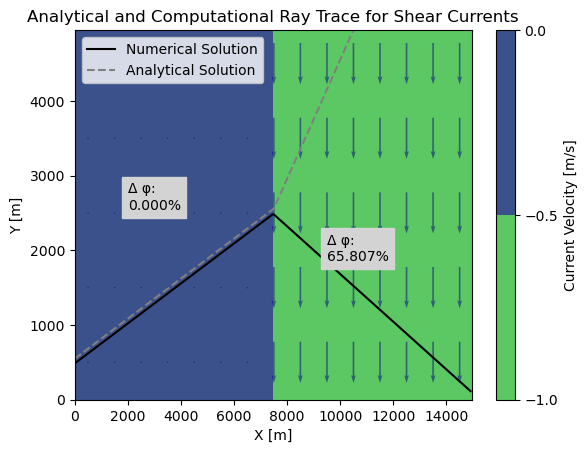

In [19]:
# Plot the Ray Comparisons
fig, ax = plt.subplots()
contours = ax.contourf(xxs, yys, currents, cmap='viridis_r', levels=np.arange(-1, 0.1, 0.5))
ax.quiver(xxs[10::20,10::20], yys[10::20,10::20], np.zeros_like(currents)[10::20,10::20], currents[10::20,10::20], color='navy',
          pivot='middle', width=0.004, alpha=0.5)
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black', label='Numerical Solution')
ax.plot(xs_analytical, ys_analytical, marker='', linestyle='dashed', color='grey', label='Analytical Solution')
for i, pcent_diff in enumerate(phi_diffs_percent):
    if i == 0:
        ax.text(x=shelf_starts[i] + 2000, y=ys_analytical[i]+2000, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
        continue
    ax.text(x=shelf_starts[i] + 2000, y=ys_analytical[i]-700, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
ax.legend()
ax.set_title(label='Analytical and Computational Ray Trace for Shear Currents')
ax.set_xlabel(xlabel='X [m]')
ax.set_ylabel(ylabel='Y [m]')
cax = fig.colorbar(contours, label='Current Velocity [m/s]')

Snell's Law (For Shear Currents in Deep Water):

$sin(\phi _2) = \frac{sin(\phi _1)}{(1-\frac{V}{c_1} sin(\phi _1))^2}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ is the phase speed of the wave before crossing the interface, and $V$ is the horizontally sheared current. 

In the deep water approximation, $c = \frac{g}{\omega _0} = \sqrt{\frac{g}{|\vec{K}|}}$, where $g$ is the acceleration of gravity, $\omega _0$ is the fundamental frequency of the wave, and $\vec{K}$ is the initial wavenumber.